In [222]:
import numpy as np
import pandas as pd

import curvesim
from curvesim.pool.stableswap.pool import CurvePool

from cauchy_simulations import CauchyLiquidityProfile, ModifiedCauchyLiquidityProfile, from_bps_tick
from cauchy_simulations.profiles.uniswap import UniswapLiquidityProfile

In [199]:
i = 0  # DAI
j = 1  # USDC
dx = 100 * 10**18

A = 250
pool = CurvePool(A=250, D=1000000 * 10**18, n=2, fee=0, admin_fee=0)
rx = pool.balances[i] / 10**18
ry = pool.balances[j] / 10**18
p = pool.dydx(i, j)

dxs = []
dys = []
ps = []
while p > 0.1:
    dy, _ = pool.exchange(i, j, dx)
    p = pool.dydx(i, j)

    dxs.append(dx / 1e18)
    dys.append(-dy / 1e18)
    ps.append(p)

In [200]:
bps_ticks = np.log(ps) / np.log(1.0001)
log_ticks = np.log(ps)

In [201]:
log_ticks

array([-1.59362499e-06, -3.18724947e-06, -4.78087419e-06, ...,
       -2.29842035e+00, -2.30085098e+00, -2.30327968e+00])

In [202]:
df = pd.DataFrame({"dxs": dxs, "dys": dys, "ps": ps, "log_ticks": log_ticks, "bps_ticks": bps_ticks})

In [203]:
df

,dxs,dys,ps,log_ticks,bps_ticks
0,100.0,-99.999920,0.999998,-0.000002,-0.015937
1,100.0,-99.999761,0.999997,-0.000003,-0.031874
2,100.0,-99.999602,0.999995,-0.000005,-0.047811
3,100.0,-99.999442,0.999994,-0.000006,-0.063748
4,100.0,-99.999283,0.999992,-0.000008,-0.079685
...,...,...,...,...,...
5580,100.0,-10.103028,0.100907,-2.293553,-22936.679535
5581,100.0,-10.078453,0.100662,-2.295988,-22961.025764
5582,100.0,-10.053956,0.100417,-2.298420,-22985.352658
5583,100.0,-10.029539,0.100174,-2.300851,-23009.660222


In [204]:
df['xs'] = df['dxs'].cumsum()
df['ys'] = df['dys'].cumsum()
df['abs(ys)'] = np.abs(df['ys'])

In [205]:
df['xs / rxs'] = df['xs'] / rx
df['abs(ys) / rys'] = df['abs(ys)'] / ry

In [206]:
df

,dxs,dys,ps,log_ticks,bps_ticks,xs,ys,abs(ys),xs / rxs,abs(ys) / rys
0,100.0,-99.999920,0.999998,-0.000002,-0.015937,100.0,-99.999920,99.999920,0.0002,0.000200
1,100.0,-99.999761,0.999997,-0.000003,-0.031874,200.0,-199.999681,199.999681,0.0004,0.000400
2,100.0,-99.999602,0.999995,-0.000005,-0.047811,300.0,-299.999283,299.999283,0.0006,0.000600
3,100.0,-99.999442,0.999994,-0.000006,-0.063748,400.0,-399.998725,399.998725,0.0008,0.000800
4,100.0,-99.999283,0.999992,-0.000008,-0.079685,500.0,-499.998008,499.998008,0.0010,0.001000
...,...,...,...,...,...,...,...,...,...,...
5580,100.0,-10.103028,0.100907,-2.293553,-22936.679535,558100.0,-492961.624084,492961.624084,1.1162,0.985923
5581,100.0,-10.078453,0.100662,-2.295988,-22961.025764,558200.0,-492971.702537,492971.702537,1.1164,0.985943
5582,100.0,-10.053956,0.100417,-2.298420,-22985.352658,558300.0,-492981.756493,492981.756493,1.1166,0.985964
5583,100.0,-10.029539,0.100174,-2.300851,-23009.660222,558400.0,-492991.786032,492991.786032,1.1168,0.985984


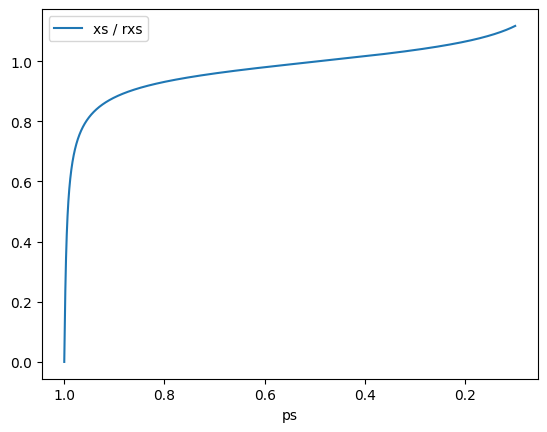

In [207]:
ax = df.plot(x='ps', y='xs / rxs')
ax.invert_xaxis()

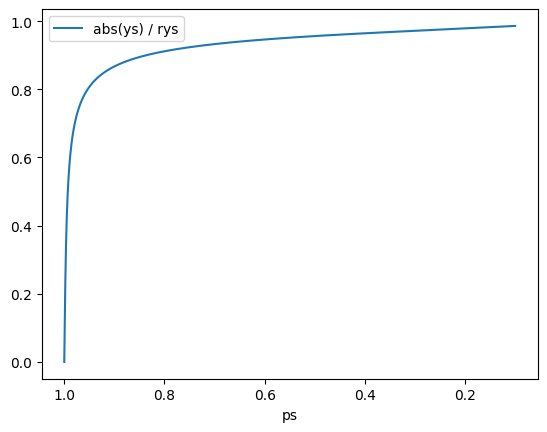

In [208]:
ax = df.plot(x='ps', y='abs(ys) / rys')
ax.invert_xaxis()

In [209]:
# compare with modified slippage curve and uniswap
C = 10.0
GAMMA = 0.0125
PEG = 16 * GAMMA
MAX_TICK = 887272
TICK_SPACING = 10  # step size between ticks in arrays

In [213]:
peg_multiples = [8, 16, 32]

In [214]:
def modified_c(c: int, pm: int) -> float:
    return c / (1 + 1/(1 + pm**2))

In [215]:
# instead plot across pegs for fixed gamma = 0.0125
for pm in peg_multiples:
    g = GAMMA
    peg = pm * g
    mc = modified_c(C, pm)
    print(f"Calculating in/out slippage quantities for gamma: {g}, peg: {peg}, and mc: {mc} ...", end='\r')

    # xout, yin and initial reserves
    df[f'xin [c={mc}, g={g}, peg={peg}]'] = df['bps_ticks'].apply(lambda t: ModifiedCauchyLiquidityProfile(c=mc, gamma=g, peg=peg).cost_x(from_bps_tick(0), from_bps_tick(t)))
    df[f'yout [c={mc}, g={g}, peg={peg}]'] = df['bps_ticks'].apply(lambda t: ModifiedCauchyLiquidityProfile(c=mc, gamma=g, peg=peg).cost_y(from_bps_tick(0), from_bps_tick(t)))
    df[f'rx0 [c={mc}, g={g}, peg={peg}]'] = df['bps_ticks'].apply(lambda t: ModifiedCauchyLiquidityProfile(c=mc, gamma=g, peg=peg).reserves_x(from_bps_tick(0), from_bps_tick(MAX_TICK)))
    df[f'ry0 [c={mc}, g={g}, peg={peg}]'] = df['bps_ticks'].apply(lambda t: ModifiedCauchyLiquidityProfile(c=mc, gamma=g, peg=peg).reserves_y(from_bps_tick(0), from_bps_tick(MAX_TICK)))

    # ratios for plotting
    df[f'xin/rx0 [c={mc}, g={g}, peg={peg}]'] = df[f'xin [c={mc}, g={g}, peg={peg}]'] / df[f'rx0 [c={mc}, g={g}, peg={peg}]']
    df[f'yout/ry0 [c={mc}, g={g}, peg={peg}]'] = df[f'yout [c={mc}, g={g}, peg={peg}]'] / df[f'ry0 [c={mc}, g={g}, peg={peg}]']
    df[f'|yout|/rx0 [c={mc}, g={g}, peg={peg}]'] = np.abs(df[f'yout [c={mc}, g={g}, peg={peg}]']) / df[f'ry0 [c={mc}, g={g}, peg={peg}]']

Calculating in/out slippage quantities for gamma: 0.0125, peg: 0.4, and mc: 9.990253411306043 ...

In [217]:
# xout, yin and initial reserves
df[f'xin [uni c={C}]'] = df['bps_ticks'].apply(lambda t: UniswapLiquidityProfile(c=C).cost_x(from_bps_tick(0), from_bps_tick(t)))
df[f'yout [uni c={C}]'] = df['bps_ticks'].apply(lambda t: UniswapLiquidityProfile(c=C).cost_y(from_bps_tick(0), from_bps_tick(t)))
df[f'rx0 [uni c={C}]'] = df['bps_ticks'].apply(lambda t: UniswapLiquidityProfile(c=C).reserves_x(from_bps_tick(0), from_bps_tick(MAX_TICK)))
df[f'ry0 [uni c={C}]'] = df['bps_ticks'].apply(lambda t: UniswapLiquidityProfile(c=C).reserves_y(from_bps_tick(0), from_bps_tick(MAX_TICK)))

# ratios for plotting
df[f'xin/rx0 [uni c={C}]'] = df[f'xin [uni c={C}]'] / df[f'rx0 [uni c={C}]']
df[f'yout/ry0 [uni c={C}]'] = df[f'yout [uni c={C}]'] / df[f'ry0 [uni c={C}]']
df[f'|yout|/rx0 [uni c={C}]'] = np.abs(df[f'yout [uni c={C}]']) / df[f'ry0 [uni c={C}]']

In [218]:
df

,dxs,dys,ps,log_ticks,bps_ticks,xs,ys,abs(ys),xs / rxs,abs(ys) / rys,...,"xin/rx0 [c=9.990253411306043, g=0.0125, peg=0.4]","yout/ry0 [c=9.990253411306043, g=0.0125, peg=0.4]","|yout|/rx0 [c=9.990253411306043, g=0.0125, peg=0.4]",xin [uni c=10.0],yout [uni c=10.0],rx0 [uni c=10.0],ry0 [uni c=10.0],xin/rx0 [uni c=10.0],yout/ry0 [uni c=10.0],|yout|/rx0 [uni c=10.0]
0,100.0,-99.999920,0.999998,-0.000002,-0.015937,100.0,-99.999920,99.999920,0.0002,0.000200,...,0.000075,-0.000075,0.000075,0.000008,-0.000008,10.0,10.0,7.968128e-07,-7.968122e-07,7.968122e-07
1,100.0,-99.999761,0.999997,-0.000003,-0.031874,200.0,-199.999681,199.999681,0.0004,0.000400,...,0.000151,-0.000151,0.000151,0.000016,-0.000016,10.0,10.0,1.593626e-06,-1.593623e-06,1.593623e-06
2,100.0,-99.999602,0.999995,-0.000005,-0.047811,300.0,-299.999283,299.999283,0.0006,0.000600,...,0.000226,-0.000226,0.000226,0.000024,-0.000024,10.0,10.0,2.390440e-06,-2.390434e-06,2.390434e-06
3,100.0,-99.999442,0.999994,-0.000006,-0.063748,400.0,-399.998725,399.998725,0.0008,0.000800,...,0.000302,-0.000302,0.000302,0.000032,-0.000032,10.0,10.0,3.187255e-06,-3.187245e-06,3.187245e-06
4,100.0,-99.999283,0.999992,-0.000008,-0.079685,500.0,-499.998008,499.998008,0.0010,0.001000,...,0.000377,-0.000377,0.000377,0.000040,-0.000040,10.0,10.0,3.984072e-06,-3.984056e-06,3.984056e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5580,100.0,-10.103028,0.100907,-2.293553,-22936.679535,558100.0,-492961.624084,492961.624084,1.1162,0.985923,...,1.144826,-0.970317,0.970317,21.480293,-6.823409,10.0,10.0,2.148029e+00,-6.823409e-01,6.823409e-01
5581,100.0,-10.078453,0.100662,-2.295988,-22961.025764,558200.0,-492971.702537,492971.702537,1.1164,0.985943,...,1.145190,-0.970353,0.970353,21.518636,-6.827274,10.0,10.0,2.151864e+00,-6.827274e-01,6.827274e-01
5582,100.0,-10.053956,0.100417,-2.298420,-22985.352658,558300.0,-492981.756493,492981.756493,1.1166,0.985964,...,1.145555,-0.970390,0.970390,21.556995,-6.831130,10.0,10.0,2.155699e+00,-6.831130e-01,6.831130e-01
5583,100.0,-10.029539,0.100174,-2.300851,-23009.660222,558400.0,-492991.786032,492991.786032,1.1168,0.985984,...,1.145920,-0.970427,0.970427,21.595370,-6.834979,10.0,10.0,2.159537e+00,-6.834979e-01,6.834979e-01


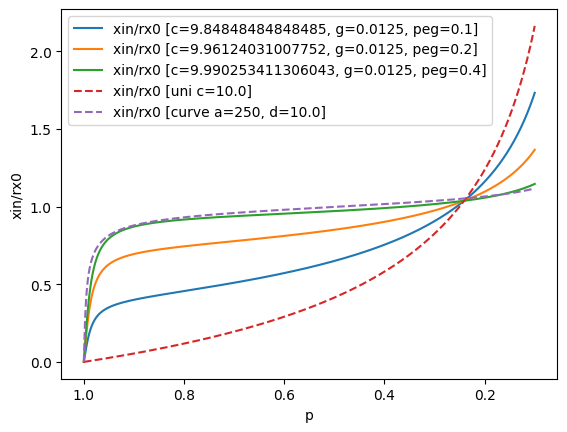

In [221]:
ax = df.plot(x='ps', y=[f'xin/rx0 [c={modified_c(C, pm)}, g={GAMMA}, peg={pm * GAMMA}]' for pm in peg_multiples] + [f'xin/rx0 [uni c={C}]'] + ['xs / rxs'], xlabel='p', ylabel=f'xin/rx0', label=[f'xin/rx0 [c={modified_c(C, pm)}, g={GAMMA}, peg={pm * GAMMA}]' for pm in peg_multiples] + [f'xin/rx0 [uni c={C}]'] + [f'xin/rx0 [curve a={A}, d={C}]'], style=['-' for _ in range(len(peg_multiples))] + ['--', '--'])
ax.invert_xaxis()

In [226]:
# compare with 0.0125 without mod as well given curve flatter than expected
print(f"Calculating in/out slippage quantities for gamma: {GAMMA}, peg: inf, and mc: {C} ...", end='\r')

# xout, yin and initial reserves
df[f'xin [mc={C}, g={GAMMA}, peg=inf]'] = df['bps_ticks'].apply(lambda t: CauchyLiquidityProfile(c=C, gamma=GAMMA).cost_x(from_bps_tick(0), from_bps_tick(t)))
df[f'yout [mc={C}, g={GAMMA}, peg=inf]'] = df['bps_ticks'].apply(lambda t: CauchyLiquidityProfile(c=C, gamma=GAMMA).cost_y(from_bps_tick(0), from_bps_tick(t)))
df[f'rx0 [mc={C}, g={GAMMA}, peg=inf]'] = df['bps_ticks'].apply(lambda t: CauchyLiquidityProfile(c=C, gamma=GAMMA).reserves_x(from_bps_tick(0), from_bps_tick(MAX_TICK)))
df[f'ry0 [mc={C}, g={GAMMA}, peg=inf]'] = df['bps_ticks'].apply(lambda t: CauchyLiquidityProfile(c=C, gamma=GAMMA).reserves_y(from_bps_tick(0), from_bps_tick(MAX_TICK)))

# ratios for plotting
df[f'xin/rx0 [mc={C}, g={GAMMA}, peg=inf]'] = df[f'xin [mc={C}, g={GAMMA}, peg=inf]'] / df[f'rx0 [mc={C}, g={GAMMA}, peg=inf]']
df[f'yout/ry0 [mc={C}, g={GAMMA}, peg=inf]'] = df[f'yout [mc={C}, g={GAMMA}, peg=inf]'] / df[f'ry0 [mc={C}, g={GAMMA}, peg=inf]']
df[f'|yout|/rx0 [mc={C}, g={GAMMA}, peg=inf]'] = np.abs(df[f'yout [mc={C}, g={GAMMA}, peg=inf]']) / df[f'ry0 [mc={C}, g={GAMMA}, peg=inf]']

Calculating in/out slippage quantities for gamma: 0.0125, peg: inf, and mc: 10.0 ...

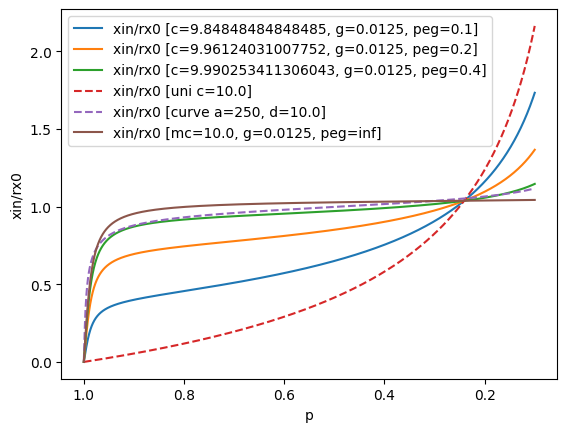

In [235]:
ax = df.plot(x='ps', y=[f'xin/rx0 [c={modified_c(C, pm)}, g={GAMMA}, peg={pm * GAMMA}]' for pm in peg_multiples] + [f'xin/rx0 [uni c={C}]'] + ['xs / rxs'] + [f'xin/rx0 [mc={C}, g={GAMMA}, peg=inf]'], xlabel='p', ylabel=f'xin/rx0', label=[f'xin/rx0 [c={modified_c(C, pm)}, g={GAMMA}, peg={pm * GAMMA}]' for pm in peg_multiples] + [f'xin/rx0 [uni c={C}]'] + [f'xin/rx0 [curve a={A}, d={C}]'] + [f'xin/rx0 [mc={C}, g={GAMMA}, peg=inf]'], style=['-' for _ in range(len(peg_multiples))] + ['--', '--'] + ['-'])
ax.invert_xaxis()